In [1]:
#  Import packages

import numpy as np
import pandas as pd
import datetime
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import plotly.graph_objects as go
# matplotlib,seaborn,pyecharts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
# plt.style.use('ggplot')  
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import missingno as msno

# ignore warnings
import warnings
warnings.filterwarnings('ignore')  

pd.set_option('display.float_format', lambda x: '%.4f' % x)

#importing the models to use 
from sklearn.ensemble import IsolationForest

In [2]:
#mounting the driver so we can access the content of google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#read data sample of 250 000
df=pd.read_csv("drive/MyDrive/Fraud detection/fraud_dataset.csv",sep=",",index_col=[0],nrows=250000)

In [4]:
#exemple de transactions
df.head(5)

,acquirerid,agriculture_list,amount,bankid,batchamount,card,construction_list,cup,datetime,emv,...,rollingsum_card_24h,rollingsum_card_merchant_24h,rollingsum_merchant_24h,rollingsum_merchant_2h,rollingsum_merchant_900s,size,super_market_list,terminal,travel_list,trc
0,9,0,106.5700,6,106.5700,250,0,0,2016-01-01 00:03:42,0,...,106.5700,106.5700,106.5700,106.5700,106.5700,-2,0,507,0,0
1,6,0,45.3500,4,45.3500,7389,0,0,2016-01-01 00:10:42,0,...,45.3500,45.3500,45.3500,45.3500,45.3500,0,0,688,0,0
2,7,0,145.2600,102,145.2600,1615,1,0,2016-01-01 00:10:42,0,...,145.2600,145.2600,145.2600,145.2600,145.2600,-1,0,100,0,1
3,3,0,803.0800,2,803.0800,5896,0,0,2016-01-01 00:11:30,1,...,803.0800,803.0800,803.0800,803.0800,803.0800,2,0,126,0,0
4,9,0,1329.5600,100,1329.5600,5245,0,0,2016-01-01 00:13:18,1,...,1329.5600,1329.5600,1329.5600,1329.5600,1329.5600,2,0,309,0,0


## Pourcentage of fraud

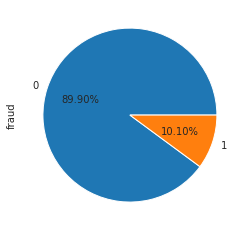

In [5]:
df['fraud'].value_counts().plot(x=None,y=None, kind='pie',autopct='%1.2f%%')

## attribut's selection

In [6]:
# we keep the hour instead of all the datetime
df["datetime"]=df["datetime"].apply(lambda x:np.datetime64(x))
df["datetime"]=df["datetime"].apply(lambda x:((x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')/3600) %24)

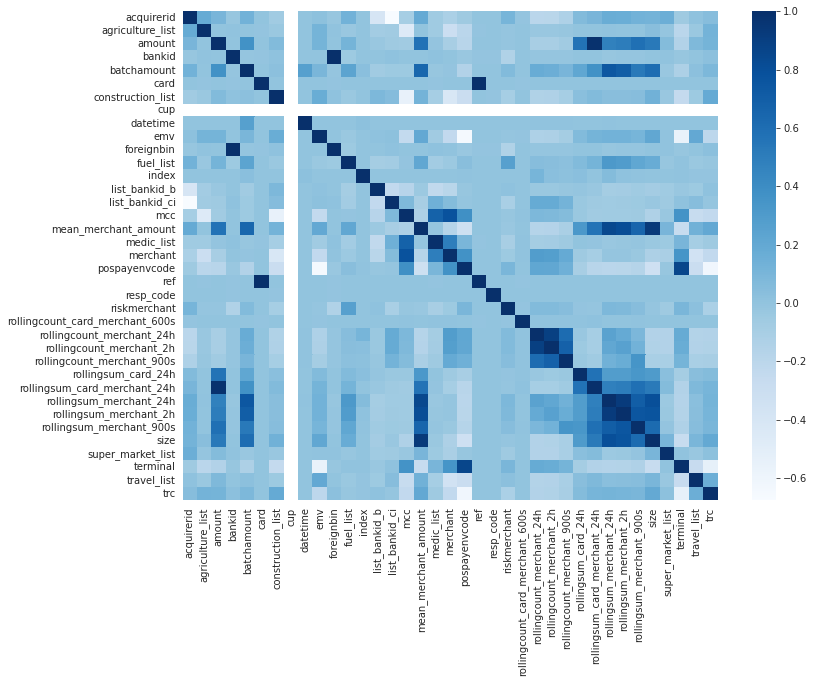

In [7]:
#we store the fraud column in a variable just to calculate the matrix of corr and we add it back
fraud_col = df.pop('fraud')
# we plot the correlation matrix
corr_matrix  = df.corr()
plt.figure(figsize=(12,9))
sns.heatmap(corr_matrix, vmax = 1, cmap = "Blues")
# add back fraud column
df['fraud'] = fraud_col
plt.show()

In [8]:
# 'cup' is a useless attribut (only zeroes)
_=df.pop("cup")

In [10]:
# after that we only keep attributs that are not correlated (cmputation done on the other notebook)
columns_to_keep = ['acquirerid', 'agriculture_list', 'rollingsum_card_merchant_24h','bankid', 'batchamount','card','emv','construction_list','mean_merchant_amount','mcc', 'list_bankid_ci', 'list_bankid_b', 'fuel_list', 'pospayenvcode','merchant', 'medic_list',
                   'rollingcount_card_merchant_600s','riskmerchant', 'resp_code', 'rollingcount_merchant_24h','rollingcount_merchant_900s','rollingsum_card_24h','rollingsum_merchant_24h','rollingsum_merchant_900s',
                   'datetime', 'trc', 'travel_list', 'terminal', 'super_market_list',"amount","size","index","fraud"]
len(columns_to_keep)

33

In [33]:
# dividing by max to have values between 0 and 1
for x in columns_to_keep:
  df[x]=df[x]/max(df[x])

## Building The model

In [11]:
# we use an architecture inspired by the model in the arcticle 4 
latent_dim = 3 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation='linear'),
      tf.keras.layers.LeakyReLU(alpha=0.4),
      layers.Dense(16, activation='linear'),
      tf.keras.layers.LeakyReLU(alpha=0.4),
      layers.Dense(8, activation='linear'),
      tf.keras.layers.LeakyReLU(alpha=0.4),
      layers.Dense(4, activation='linear'),
      tf.keras.layers.LeakyReLU(alpha=0.4),
      layers.Dense(latent_dim, activation='linear'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(4, activation='linear'),
      tf.keras.layers.LeakyReLU(alpha=0.4),
      layers.Dense(8, activation='linear'),
      tf.keras.layers.LeakyReLU(alpha=0.4),
      layers.Dense(16, activation='linear'),
      tf.keras.layers.LeakyReLU(alpha=0.4),
      layers.Dense(32, activation='linear'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 


In [12]:
#compiling the model
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [34]:
# we keep only columns_to_keep
df=df[columns_to_keep]
# we take 150 000 line for training+valid
df_tv=df[:150000]
# we take out the frauds
df_tv=df_tv[df_tv["fraud"]==0]
#we take out labels because we don't need them for training
labels_tv=df_tv.pop("fraud")
# we take 50 000 for test1 and 50 000 for test 2
df_test=df[150000:200000]
df_test2=df[200000:]
labels_test=df_test.pop("fraud")
labels_test2=df_test2.pop("fraud")

In [35]:
len(df_tv)

134849

In [36]:
# 120 000 for training and 15 000 for validation
df_train=df_tv[:120000]
df_valid=df_tv[120000:]
#df_train=df_train[df_train[""]]
x_train=df_train.values
x_valid=df_valid.values
x_test=df_test.values
x_test2=df_test2.values

In [40]:
# Shape of data
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(x_test2.shape)
x_valid[0]

(120000, 32)
(14849, 32)
(50000, 32)
(50000, 32)


array([ 0.1       ,  0.        ,  0.01129929,  0.05882353,  0.06252407,
        0.4678    ,  0.        ,  0.        ,  0.12424737,  0.98913446,
        1.        ,  0.        ,  0.        ,  1.        ,  0.81      ,
        1.        ,  0.5       ,  0.        ,  0.        ,  0.3994709 ,
        0.0952381 ,  0.01627744,  0.07142777,  0.01475427,  0.77831794,
        0.        ,  0.        ,  0.74571429,  0.        ,  0.01169466,
       -0.5       ,  0.53436059])

In [41]:
#training the model
hist=autoencoder.fit(x_train, x_train,
                epochs=30,
                shuffle=True,
                validation_data=(x_valid, x_valid))

Epoch 1/30
3750/3750 [==============================] - 6s 1ms/step - loss: 0.0366 - val_loss: 0.0280
Epoch 2/30
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0246 - val_loss: 0.0254
Epoch 3/30
3750/3750 [==============================] - 9s 2ms/step - loss: 0.0221 - val_loss: 0.0230
Epoch 4/30
3750/3750 [==============================] - 6s 2ms/step - loss: 0.0203 - val_loss: 0.0218
Epoch 5/30
3750/3750 [==============================] - 6s 2ms/step - loss: 0.0195 - val_loss: 0.0214
Epoch 6/30
3750/3750 [==============================] - 7s 2ms/step - loss: 0.0190 - val_loss: 0.0209
Epoch 7/30
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0187 - val_loss: 0.0207
Epoch 8/30
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0185 - val_loss: 0.0206
Epoch 9/30
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0183 - val_loss: 0.0204
Epoch 10/30
3750/3750 [==============================] - 5s 1ms/step - loss: 0.018

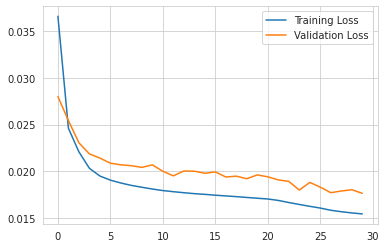

In [42]:
# plotting the errors
plt.plot(hist.history["loss"], label="Training Loss")
plt.plot(hist.history["val_loss"], label="Validation Loss")
plt.legend()

In [44]:
# computing on test 1
reconst_test = autoencoder.predict(x_test)
train_loss_test = tf.keras.losses.mse(reconst_test, x_test).numpy()

## Repartition fraud/normal

In [45]:
xx1=[]
xx2=[]
y1=[]
y2=[]
for i in range(50000):
  start=labels_test.index[0]
  if labels_test[start+i]==0:
    xx1.append(i)
    y1.append(min(train_loss_test[i],1))
  else:
    xx2.append(i)
    y2.append(min(train_loss_test[i],1))
fig = go.Figure(data=go.Scatter(x=xx1, y=y1,mode="markers",name="Normal"))
fig.add_trace(go.Scatter(x=xx2, y=y2,mode="markers",name="Fraud"))
fig.show()


## Testing different thresholds

In [47]:
threshold=np.linspace(0,0.15,100)
accuracy=[]
precision=[]
recall=[]
f1_score=[]
for x in threshold:
  TP=0
  TN=0
  FP=0
  FN=0
  for i in range(len(train_loss_test)):
    start=labels_test.index[0]
    if train_loss_test[i]>=x and labels_test[start+i]==1:
      TP+=1
    if train_loss_test[i]>=x and labels_test[start+i]==0:
      FP+=1
    if train_loss_test[i]<x and labels_test[start+i]==1:
      FN+=1
    if train_loss_test[i]<x and labels_test[start+i]==0:
      TN+=1
  accuracy.append((TP+TN)/(TP+TN+FP+FN))
  pre=TP/(TP+FP)
  rec=TP/(TP+FN)
  precision.append(pre)
  recall.append(rec)
  f1_score.append(2*pre*rec/(pre+rec))

In [48]:
fig = go.Figure(data=go.Scatter(x=threshold, y=accuracy,name="accuracy"))
fig.add_trace(go.Scatter(x=threshold, y=precision,name="precision"))
fig.add_trace(go.Scatter(x=threshold, y=recall,name="recall"))
fig.add_trace(go.Scatter(x=threshold, y=f1_score,name="f1_score"))
fig.show()

In [49]:
# we take threshold arround 0.05 !

In [50]:
print(f'threshold = {threshold[33]}')
print(f'accuracy = {accuracy[33]}')
print(f'Precision = {precision[33]}')
print(f'recall = {recall[33]}')
print(f'f1_score = {f1_score[33]}')

threshold = 0.05
accuracy = 0.95204
Precision = 0.8005959202383681
recall = 0.6956781517625971
f1_score = 0.7444586530264279


## testing on test 2 with 0.05 as threshold

In [51]:
reconst_test2=autoencoder.predict(x_test2)
train_loss_test2 = tf.keras.losses.mse(reconst_test2, x_test2).numpy()

In [54]:
TP=0
TN=0
FP=0
FN=0

for i in range(len(train_loss_test2)):
  start=labels_test2.index[0]
  if train_loss_test2[i]>=0.05 and labels_test2[start+i]==1:
      TP+=1
  if train_loss_test2[i]>=0.05 and labels_test2[start+i]==0:
    FP+=1
  if train_loss_test2[i]<0.05 and labels_test2[start+i]==1:
    FN+=1
  if train_loss_test2[i]<0.05 and labels_test2[start+i]==0:
    TN+=1
acc=(TP+TN)/(TP+TN+FP+FN)
pre=TP/(TP+FP)
rec=TP/(TP+FN)

In [55]:
print(f'accuracy2 = {acc}')
print(f'Precision2 = {pre}')
print(f'recall2 = {rec}')
print(f'f1_score2 = {2*pre*rec/(rec+pre)}')

accuracy2 = 0.93658
Precision2 = 0.6546867411364741
recall2 = 0.7957497048406139
f1_score2 = 0.7183586464162004
